## Bag of words 

Documents are traditionally represented with the vector space model, also known as the bag-of-words representation.

With this approach, each document $d_{i}$ from the collection $D=\{d_{1} \dots d_{m}\}$ of size $m$ is associated with an $n$-dimensional feature vector, where $n$ is the number of unique terms in the preprocessed collection.
The set of unique terms $T=\{t_{1} \dots t_{n}\}$ is called the vocabulary.

## TF-IDF

Term Frequency-Inverse Document Frequency (TF-IDF), is a method used to compute the coordinates of a document in the vector space.

The assumption is that the importance of a word to a document increases when its frequency increases.
However, considering the frequency as the only factor to judge the importance of a word would result in giving greater weight to commonly used terms such as stopwords, which could be misleading in many tasks.
TF-IDF mitigates this problem by introducing a factor that diminishes the weight of words that occur frequently in other documents in the same collection.
The TF-IDF weight computation is based on the product of two separate factors, namely the Term Frequency (TF) and the Inverse Document Frequency (IDF).
More specifically:

\begin{equation}
\mathrm{weight}(t,d,D) = tf(t,d) \times idf(t,D)
\end{equation}

There are many ways to determine $tf$ and $idf$. In our case, $tf(t,d)$ is the number of times term $t$ appears in document $d$, and $idf(t,D) = \ln \big( \frac{m}{1+df(t)} \big) + 1 $, with $df(t)$ the number of documents in the collection $D$ that contains $t$.
We can notice that the weight of a term in a document increases when its frequency increases in this document (first factor), and decreases when the number of documents in the collection containing this term increases (second factor).
$M \in \mathbb{R}^{m \times n}$ is the TF-IDF matrix of $D$, where $M_{ij}$ is the TF-IDF weight of the $jth$ word in the $ith$ document.

In the following we provide a simple implementation of this approach using numpy only. Note that we can use scikit-learn to compute the TF-IDF matrix, however we prefered to implement it ourselves for educational purposes.

When initialized, a _tfidf_ object takes as input a collection of documents and computes the IDF of words in this collection.
We can provide a list of stopwords to be ignored, and we can specify the minimun number of occurences of a word allowing it to be included in our vocabulary. And finally we can choose a maximum size of the vocabulary. 

Two important methods are defined in this class: _tf_ that returns the frequency of unique words in a document and _transform_ that returns the TF-IDF matrix of the collection.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np

class Tfidf(object):
    def __init__(self, collection, stop_words=[], min_count=3 ,max_vocab=50000):
        '''collection is a list of strings'''
        self.word2count = {} # map each word to its total number of occurences in the whole collection
        self.word2count_doc = {} # map each word to the number of documents in which it appears
        self.word2ind = {} # map each word in the collection to a unique index
        self.ind2word = {}
        self.word2idf = {} # map each word to its idf
        self.collection = collection
        self.documents = [document.split() for document in collection]
        
        for document in self.documents:
            document_unique_words = set()
            for word in document:
                document_unique_words.add(word)
                self.word2count[word] = self.word2count.get(word, 0) + 1
            for word in document_unique_words:
                self.word2count_doc[word] = self.word2count_doc.get(word, 0) + 1
                  
        self.word2count = {el[0]:el[1] for el in sorted(self.word2count.items(), key=lambda item: item[1],
                                                        reverse=True)} # sort by values (descending)
        self.unique_words = [word for word in self.word2count.keys() if word not in stop_words \
                             and self.word2count[word] > min_count] # remove stopwords
        self.unique_words = list(self.unique_words)[:max_vocab]
        self.count_unique_words = len(self.unique_words)
        self.word2ind = dict(zip(self.unique_words,range(self.count_unique_words)))
        self.ind2word = {v:k for k,v in self.word2ind.items()}
        self.count_documents = len(collection)        
        
        # compute the idf of unqiue words in the collection
        for word in self.word2ind.keys():
            count = self.word2count_doc[word]
            idf = np.log(self.count_documents / (1 + count)) + 1 
            self.word2idf[word] = idf

    def getWordFromInd(self, ind):
        return self.ind2word[ind]

    def getListWords(self):
        return self.unique_words

    def tf(self, document):
        '''
        return the frequency of each unique word in document
        document is a list of strings
        '''
        word2frequency = {}
        for word in document:
            word2frequency[word] = word2frequency.get(word, 0) + 1 # increment, creating key if it doesn't already exist
        return word2frequency

    def transform(self, collection):
        '''
        returns the tfidf matrix of a collection of documents of dimension n_doc * vocab_size
        collection is a list of strings
        '''
        documents = [document.split() for document in collection] # tokenize documents in the collection
        tfidf_mat = np.zeros((len(documents), self.count_unique_words)) # intialize tfidf matrix with zeros
        # compute tfidf 
        for ind, document in enumerate(documents):
            word2frequency = self.tf(document)
            for word in word2frequency.keys():
                if word in self.word2ind:
                    tfidf_mat[ind, self.word2ind[word]] = word2frequency[word] * self.word2idf[word]        
        return tfidf_mat

## Supervised Classification

In the following we start by computing the TF-IDF matrix of the train set, and we train a simple logistic regression model on this subset using scikit-learn. Then we load the test set and we compute its TF-IDF matrix as well. Note that the documents in the test set are represented in the space made of the unique terms in the training set __only__ (words in the test set absent from the training set are disregarded).

The trained model will then be used to predict the classes of the test documents. The predicted labels will finally be compared with the true labels to calculate the accuracy of the classifier.

In [2]:
import os
data_path = 'data'

def read_data(subset):
    with open(os.path.join(data_path, '{}_documents.txt'.format(subset)), 'r') as f1, \
        open(os.path.join(data_path, '{}_labels.txt'.format(subset)), 'r') as f2:
        documents = []
        labels = []
        for line in f1:
            documents.append(line)
        f1.close()
        for line in f2:
            labels.append(int(line))
        return documents, labels
              

collection_train, labels_train = read_data('train')
# collection_valid, labels_valid = read_data('valid')
collection_test, labels_test = read_data('test')

In [3]:
tfidf = Tfidf(collection_train)
X_train = tfidf.transform(collection_train)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
classifier = LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=200)
classifier.fit(X_train, labels_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [5]:
X_test = tfidf.transform(collection_test)
y_test_predicted = classifier.predict(X_test)
accuracy = (sum(y_test_predicted == labels_test) / len(labels_test)) * 100
print('Test accuracy: {}%'.format(accuracy))

Test accuracy: 93.72%


## Visualizing important features.

In the following we use the regression coefficients of the multinomial logistic regressor. Then we visualize the relevant features (words) for each category.

We use arabic_reshaper package (https://github.com/mpcabd/python-arabic-reshaper) to fix arabic text display in matplotlib.

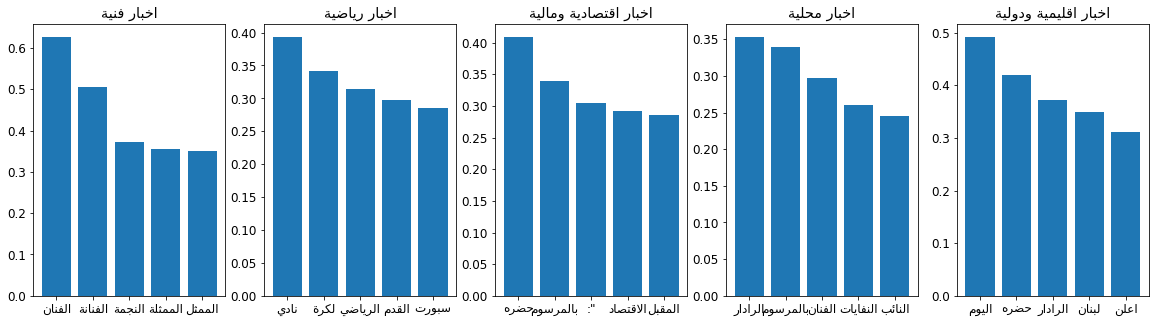

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import arabic_reshaper
from bidi.algorithm import get_display

ind2cat = {}
with open('data/cat2ind.csv', 'r') as f:
    for line in f:
        tmp = line.strip().split(',')
        ind2cat[int(tmp[1])] = tmp[0]
    f.close()

categories = ind2cat.values()
categories_reshaped = [get_display(arabic_reshaper.reshape(el)) for el in categories] # nice arabic text display
plt.figure(figsize=(20, 5))
plt.rc('font', size=12)
for label in ind2cat.keys():
    arr = np.abs(classifier.coef_[label])
    top5 = np.argsort(-arr)[:5]
    plt.subplot(1, 5, label+1)
    plt.title(categories_reshaped[label])
    top_words = [tfidf.ind2word[index] for index in top5]
    top_words = [get_display(arabic_reshaper.reshape(el)) for el in top_words]
    plt.bar(top_words, arr[list(top5)])